### 1.라이브러리 불러오기

In [4]:
import warnings

In [5]:
warnings.filterwarnings(action="ignore")

In [6]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

### 2. 데이터 불러오기 및 분리

In [9]:
traindir = "../images/mnist/trainingSet/"
testdir = "../images/mnist/testSet/"

In [10]:
IMG_SIZE = 32

In [13]:
def data_load (rootdir, in_img_size, ):
    imageList = []
    labelList = []
    IMG_SIZE = in_img_size
    categories = os.listdir(rootdir)
    # 폴더 순환
    for i in range (0, len(categories)):
        labelPath = os.path.join(rootdir,categories[i])
        imagePath = os.listdir(labelPath)
        # 이미지 순환
        for j in range(0, len(imagePath)):
            imageFullPath = os.path.join(labelPath, imagePath[j])
            try:
                baseImg = cv2.imread(imageFullPath, cv2.IMREAD_COLOR)
                ### 1. 이미지 사이즈 변경
                refinedImg = cv2.resize(baseImg, (IMG_SIZE,IMG_SIZE))
                imageList.append(refinedImg)
                labelList.append(i)
            except Exception as e:
                print(e, imageFullPath)
                pass

    imageArray = np.array(imageList)
    labelArray = np.array(labelList)
    
    
    return imageArray, labelArray

In [14]:
## use of application

In [15]:
x_train, y_train = data_load(traindir, IMG_SIZE)
x_test, y_test = data_load(testdir, IMG_SIZE)

OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
 ../images/mnist/trainingSet/0_zero\desktop.ini


In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(42000, 32, 32, 3)
(42000,)
(200, 32, 32, 3)
(200,)


In [19]:
trainingData_features_norm = x_train/255.0
testData_features_norm = x_test/255.0

In [20]:
### 접답지는 softmax랑 결합을 위한 onehot encoding

In [21]:
from tensorflow.keras.utils import to_categorical

In [22]:
trainingData_labels_one = to_categorical(y_train)
testData_labels_one = to_categorical(y_test)

In [23]:
trainingData_labels_one[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### 3. 모델 생성

In [37]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [25]:
inputShape = trainingData_features_norm[0].shape
inputShape

(32, 32, 3)

In [30]:
outputShape = len(np.unique(y_train))
outputShape

10

In [32]:
from tensorflow.keras.applications.vgg16 import VGG16

In [33]:
vgg_model = VGG16(weights=None, include_top=False)

In [39]:
# 커스텀 input_shape 생성
keras_input = Input(shape=inputShape, name = 'custom_input')
keras_input.shape
# 커스텀모델 생성 
vgg_model_c = vgg_model(inputs=keras_input)

# Fully Connected Layer 추가 생성 
x = Flatten(name='flatten')(vgg_model_c)
x = Dense(64, activation="relu", name='custom_1')(x)
x = Dense(64, activation="relu", name='custom_2')(x)
x = Dense(outputShape, activation='softmax', name='prediction')(x)

# 커스텀 모델 생성
pretrained_model = Model(inputs=keras_input, outputs=x)
pretrained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
custom_1 (Dense)             (None, 64)                32832     
_________________________________________________________________
custom_2 (Dense)             (None, 64)                4160      
_________________________________________________________________
prediction (Dense)           (None, 10)                650       
Total params: 14,752,330
Trainable params: 14,752,330
Non-trainable params: 0
_________________________________________________

In [40]:
pretrained_model.compile(loss="categorical_crossentropy", 
              optimizer= "adam",
              metrics=["accuracy"] )

In [ ]:
pretrained_model.fit(x=trainingData_features_norm,
                     y=trainingData_labels_one,
                    epochs=3,
                    validation_data = (testData_features_norm, testData_labels_one))

Train on 42000 samples, validate on 200 samples
Epoch 1/3
22304/42000 [==============>...............] - ETA: 26:49 - loss: 2.3032 - accuracy: 0.1077

In [28]:
from tensorflow.keras import Sequential

In [29]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [30]:
# 모델생성 시작
model = Sequential()

In [31]:
model.add(Conv2D(filters=32,
                 kernel_size=3, 
                 padding="same", 
                 activation="relu",
                 input_shape=inputShape))

In [32]:
model.add(MaxPooling2D(pool_size= 2 ))

In [33]:
model.add(Dropout(rate=0.4)) # 사용한 비율을 설정

In [34]:
model.add(Conv2D(filters=32,
                 kernel_size=3, 
                 padding="same", 
                 activation="relu",
                 input_shape=inputShape))

In [35]:
model.add(MaxPooling2D(pool_size= 2 ))

In [36]:
model.add(Flatten())

In [37]:
model.add(Dense(units=outputShape, activation="softmax"))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3

In [39]:
from tensorflow.keras.utils import plot_model

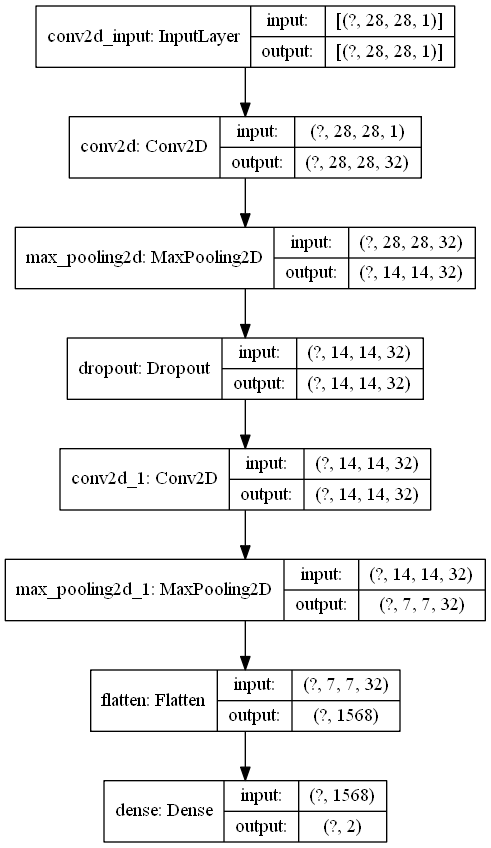

In [40]:
plot_model(model, show_shapes=True)

### 4. 모델 컴파일 (loss, metrics, optimizer)

In [41]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer= keras.optimizers.Adam(),
              metrics=["accuracy"] )

In [42]:
model.compile(loss="categorical_crossentropy", 
              optimizer= "adam",
              metrics=["accuracy"] )

### 5. 모델 학습(훈련)

In [43]:
epochNo = 5

In [44]:
len(trainingData_features_norm)

16000

In [45]:
33600 / 32

1050.0

In [46]:
model.fit(x=trainingData_features_norm, 
          y=trainingData_labels_one,
          epochs=epochNo,
          batch_size=32,
          validation_data=(testData_features_norm, testData_labels_one) )

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 13s 791us/sample - loss: 0.6677 - accuracy: 0.5818 - val_loss: 0.6135 - val_accuracy: 0.6722
Epoch 2/5
16000/16000 [==============================] - 12s 734us/sample - loss: 0.6063 - accuracy: 0.6686 - val_loss: 0.6013 - val_accuracy: 0.6745
Epoch 3/5
16000/16000 [==============================] - 12s 731us/sample - loss: 0.5781 - accuracy: 0.7001 - val_loss: 0.5640 - val_accuracy: 0.7138
Epoch 4/5
16000/16000 [==============================] - 13s 798us/sample - loss: 0.5547 - accuracy: 0.7212 - val_loss: 0.5634 - val_accuracy: 0.7135
Epoch 5/5
16000/16000 [==============================] - 13s 794us/sample - loss: 0.5389 - accuracy: 0.7321 - val_loss: 0.5380 - val_accuracy: 0.7293


### 6. 모델 추론

In [105]:
model.evaluate(x = testData_features_norm,
               y = testData_labels_one)

8400/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.049059808233398054, 0.9842857]

### 7. 모델 예측

In [131]:
def refineImage(testImg):

    # 사이즈 조정
    IMG_SIZE=28  
    # 컬러이미지 -> 회색톤으로 변경
    img_gray = cv2.cvtColor(testImg, cv2.COLOR_RGB2GRAY)
    img_resize = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
    ### shape 변경
    img_shape = img_resize.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    ### 정규화
    img_norm = img_shape/255.0
    return img_norm

In [132]:
testData = cv2.imread("d:/sample_mnist.JPG", cv2.IMREAD_COLOR)

In [133]:
refinedImageOne = refineImage(testData)

In [135]:
predictValue = np.argmax(model.predict(refinedImageOne))
predictValue

5

### 모델 저장

In [138]:
# 모델구조저장
model_json = model.to_json()

In [137]:
with open("d:/model_mnist.json","w") as json_file:
    json_file.write(model_json)

In [139]:
model.save_weights("d:/model_mnist_weight.h5")